In [1]:
#Library needed to create visualisation
library(tidyverse)
library(readr)
library(janitor)
library(lubridate)
library(stringr)
library(scales)
library(ggrepel)
library(repr)

options(repr.plot.width=10, repr.plot.height=8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
#Load data to the report

grocery_dataset <- read_csv(
    "../input/supermart-grocery-sales-retail-analytics-dataset/Supermart Grocery Sales - Retail Analytics Dataset.csv"
    ) %>% 
    clean_names

Rows: 9994 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Order ID, Customer Name, Category, Sub Category, City, Order Date, ...
dbl (3): Sales, Discount, Profit

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Take a look at how the data look like

str(grocery_dataset)

spec_tbl_df [9,994 × 11] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ order_id     : chr [1:9994] "OD1" "OD2" "OD3" "OD4" ...
 $ customer_name: chr [1:9994] "Harish" "Sudha" "Hussain" "Jackson" ...
 $ category     : chr [1:9994] "Oil & Masala" "Beverages" "Food Grains" "Fruits & Veggies" ...
 $ sub_category : chr [1:9994] "Masalas" "Health Drinks" "Atta & Flour" "Fresh Vegetables" ...
 $ city         : chr [1:9994] "Vellore" "Krishnagiri" "Perambalur" "Dharmapuri" ...
 $ order_date   : chr [1:9994] "11-08-2017" "11-08-2017" "06-12-2017" "10-11-2016" ...
 $ region       : chr [1:9994] "North" "South" "West" "South" ...
 $ sales        : num [1:9994] 1254 749 2360 896 2355 ...
 $ discount     : num [1:9994] 0.12 0.18 0.21 0.25 0.26 0.26 0.33 0.32 0.23 0.27 ...
 $ profit       : num [1:9994] 401.3 149.8 165.2 89.6 918.5 ...
 $ state        : chr [1:9994] "Tamil Nadu" "Tamil Nadu" "Tamil Nadu" "Tamil Nadu" ...
 - attr(*, "spec")=
  .. cols(
  ..   `Order ID` = col_character(),
  ..   `Custom

In [4]:
#Data Overview and Data Cleansing

grocery_dataset$order_date <- str_replace_all(grocery_dataset$order_date,"/","-")

grocery_dataset$order_date <- as.Date(grocery_dataset$order_date, "%m-%d-%Y")

grocery_dataset$month <- month.abb[as.numeric(format(grocery_dataset$order_date, "%m"))] #Month Abbreviation Field

grocery_dataset$month_num <- as.numeric(format(grocery_dataset$order_date, "%m")) #Month number Field

grocery_dataset$year <- format(grocery_dataset$order_date, "%Y") #Year Field

head(grocery_dataset)

order_id,customer_name,category,sub_category,city,order_date,region,sales,discount,profit,state,month,month_num,year
<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,Tamil Nadu,Nov,11,2017
OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.18,149.80,Tamil Nadu,Nov,11,2017
OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.21,165.20,Tamil Nadu,Jun,6,2017
OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.25,89.60,Tamil Nadu,Oct,10,2016
OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.26,918.45,Tamil Nadu,Oct,10,2016
OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,2015-06-09,West,2305,0.26,322.70,Tamil Nadu,Jun,6,2015


Clean date format inconsistency by replace "/" with "-" in some date cells and make the date in the YYY-MM-DD format which will make it easier to work with

In [5]:
#Data Overview

sales_by_region <- grocery_dataset %>% group_by(region) %>% summarise(sales = sum(sales),
                                                            profit = sum(profit))

sales_by_region$perct_profit <- (sales_by_region$profit / sales_by_region$sales)*100

sales_by_region[order(sales_by_region$sales, decreasing = TRUE),]

region,sales,profit,perct_profit
<chr>,<dbl>,<dbl>,<dbl>
West,4798743,1192004.61,24.83993
East,4248368,1074345.58,25.28843
Central,3468156,856806.84,24.70497
South,2440461,623562.89,25.55103
North,1254,401.28,32.00000


**Explanation**

Percent profit from each region is close to the same amount but the large amount of revenue came from West and East Region as shown in the table.

`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.


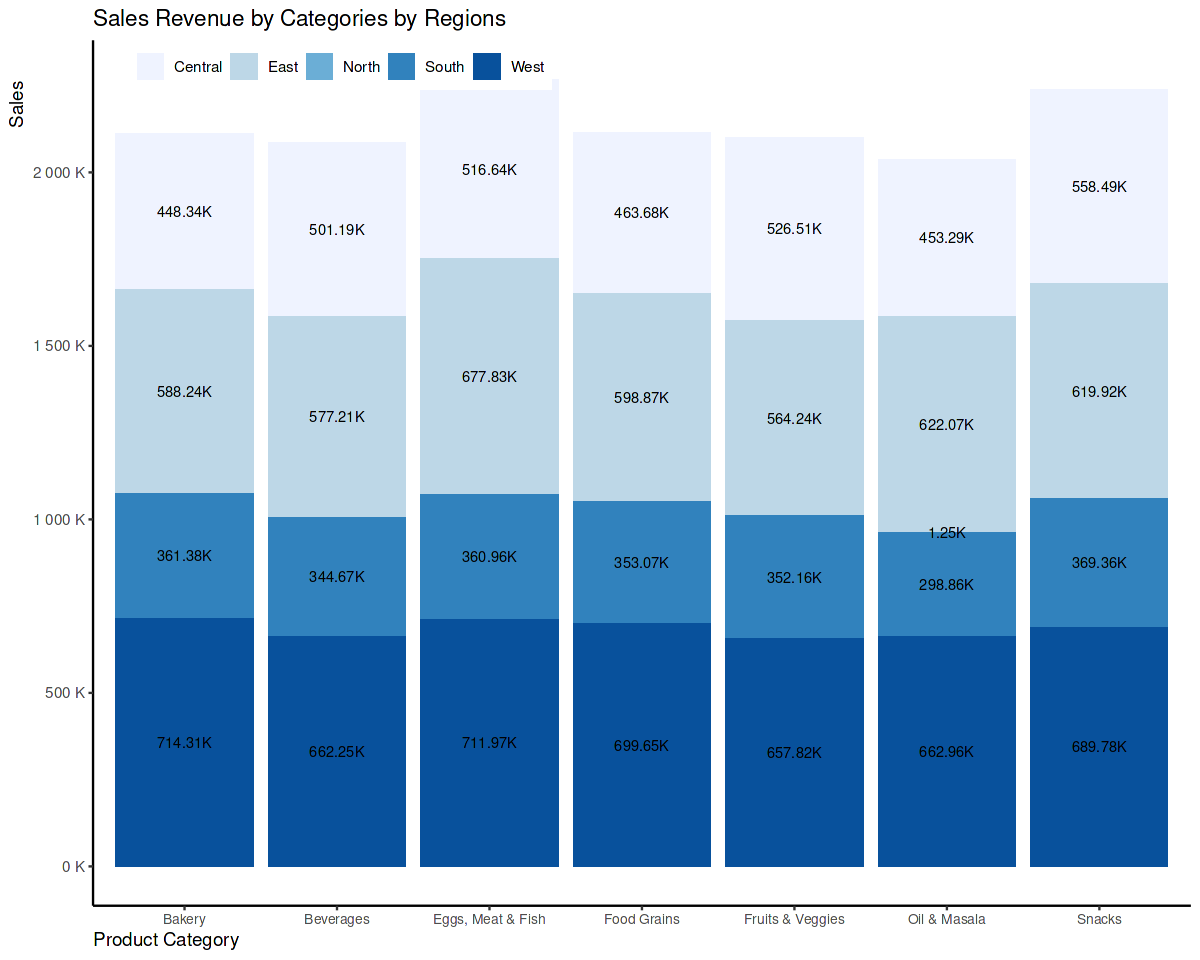

In [6]:
#Which product make sales revenue the most?

#Using ggplot package to create charts

sales_by_cat <- grocery_dataset %>% group_by(category, region) %>% summarise(sales = sum(sales),
                                                            profit = sum(profit))

ggplot(sales_by_cat, aes(fill=region, y = sales, x = category)) + 
geom_bar(stat="identity") + 
geom_text(aes(label =label_number(scale=1e-3, suffix='K')(sales)), position = position_stack(vjust = .5), size =3) + 
theme_classic() +
theme(axis.text.x = element_text(size = 8)) +
scale_fill_brewer() + 
scale_y_continuous(labels = label_number(suffix = " K", scale = 1e-3)) +
xlab("Product Category") +
ylab("Sales") +
theme(axis.title.x = element_text(hjust = 0),
      axis.title.y = element_text(hjust = 0.95),
     legend.position = c(0.22,0.97),
     legend.direction = "horizontal",
     legend.title = element_blank()) +
ggtitle("Sales Revenue by Categories by Regions")

**Explanation**

- West region was the main source of revernue with the most sales in every product category. 

- South and North region provide the least revenue to the company. The result left much room to improve on in order to gain more revenue. 

- By adjusting sales strategy on the South and North region will definitely improve company sales revenue. 

- Almost every categories had
no sales in the North region except the small portion from Oil & Masala category, this might indicate the number of store opened in the region. 

- This is the opportunity that the company should open more stores in the North region to gain more customer and of course more income.

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


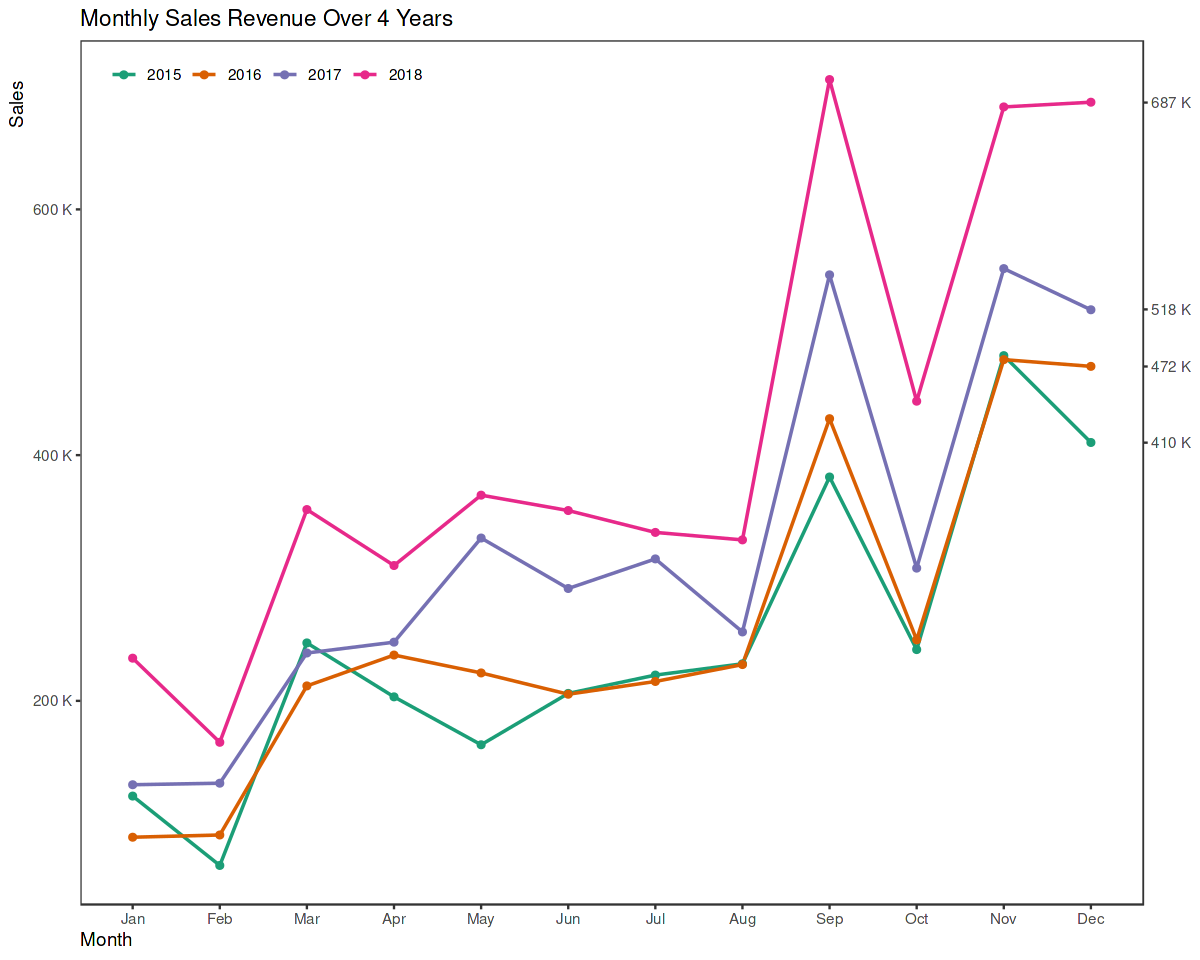

In [7]:
#How is the sales over the period of time?

monthly_sales <- grocery_dataset %>% 
    group_by(year, month, month_num) %>% 
    summarise(sales = sum(sales), profit = sum(profit)) %>%
    arrange(year, month_num)

data_ends <- monthly_sales %>% filter(month_num == 12)
sales_end_points <- data_ends$sales

ggplot(monthly_sales, aes(x= factor(monthly_sales$month, levels = c("Jan", "Feb", "Mar", "Apr", 
                                                                   "May", "Jun", "Jul", "Aug", 
                                                                   "Sep", "Oct", "Nov", "Dec")), y=sales, group=year)) + 
geom_line(aes(color = year), size = 0.75) + 
geom_point(aes(color = year)) +
theme_bw() +
xlab("Month") +
ylab("Sales") +
scale_y_continuous(labels = label_number(suffix = " K", scale = 1e-3), 
                   sec.axis = sec_axis(~ ., breaks = sales_end_points, labels = label_number(suffix = " K", scale = 1e-3))) +
scale_color_brewer(palette = "Dark2") +
theme(axis.title.x = element_text(hjust = 0),
      axis.title.y = element_text(hjust = 0.95),
     legend.position = c(0.17,0.96),
     legend.direction = "horizontal",
     legend.title = element_blank(),
     panel.grid.major = element_blank(),
     panel.grid.minor = element_blank()) +
ggtitle("Monthly Sales Revenue Over 4 Years")


**Explanation**

- Overall sales revenue increased every year. Sales growth usually peaked on September and then dramatically dropped in the following month and then peaked again on November. 

- This up and suddent drop trend was found throughout 4 years of sales. My suggestion is to further investigate into what caused this situation so that the company can make an improvement on this unusual trend.

- But overall sales revenue increase every year.


`summarise()` has grouped output by 'category', 'month', 'month_num'. You can
override using the `.groups` argument.


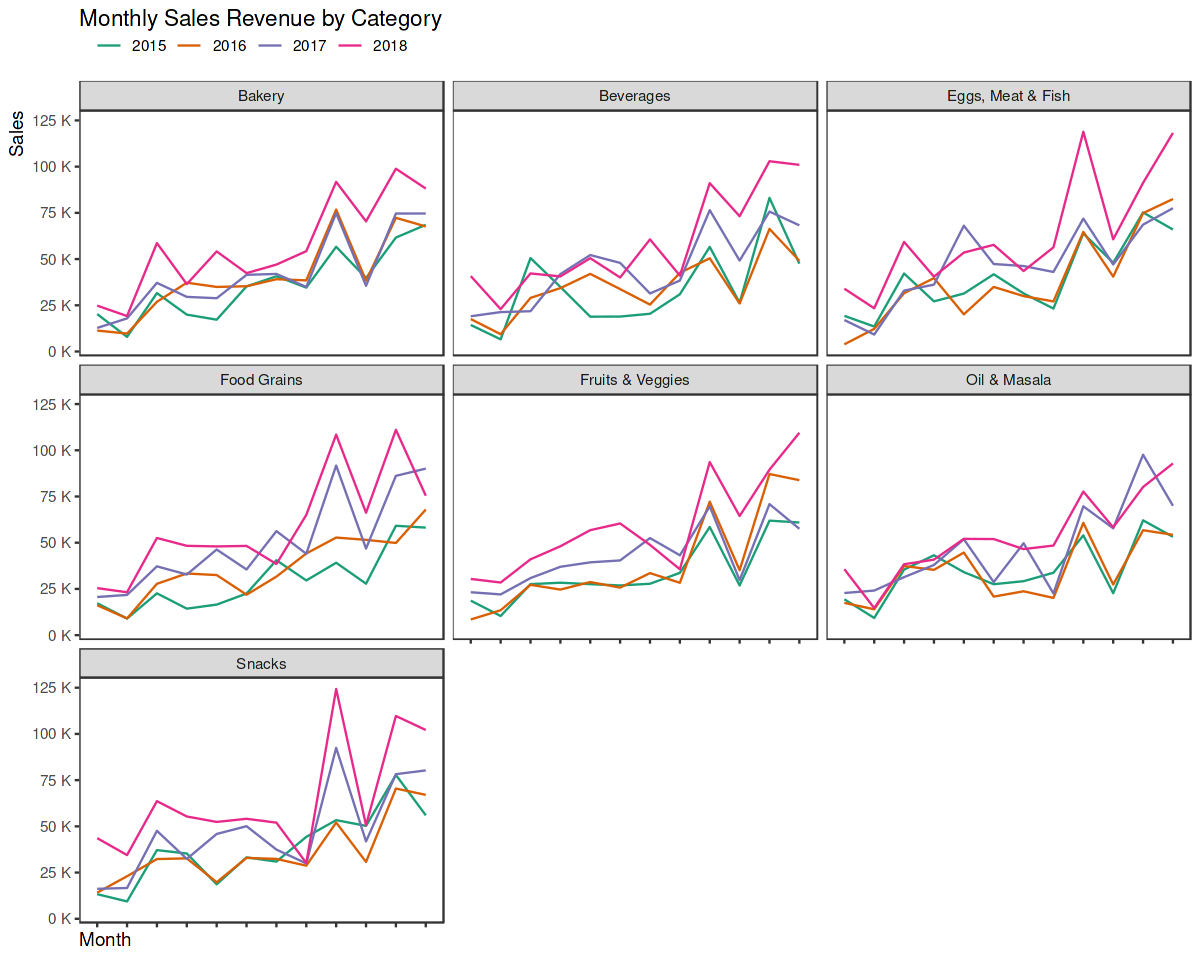

In [8]:
#What about sales by categories ? Is It following the overall trend?

sales_by_category_by_month <- grocery_dataset %>% 
    group_by(category, month, month_num, year) %>%
    summarise(sales = sum(sales)) %>% arrange(category, month_num)

ggplot(sales_by_category_by_month, 
       aes(x = factor(sales_by_category_by_month$month, levels = c("Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep", "Oct","Nov", "Dec")),
          y = sales, group = year)) +
geom_line(aes(color = year)) +
theme_bw() +
scale_y_continuous(labels = label_number(suffix = " K", scale = 1e-3)) +
theme(axis.text.x=element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      axis.title.x = element_text(hjust = 0),
      axis.title.y = element_text(hjust = 1),
      legend.position = c(0.15,1.08),
      legend.direction = "horizontal",
      legend.title = element_blank(),
      plot.title = element_text(margin=margin(0,0,30,0))) +
scale_color_brewer(palette = "Dark2") +
ylab("Sales") +
xlab("Month") +
facet_wrap(~category) + 
ggtitle("Monthly Sales Revenue by Category")

**Explanation**

- The up and suddent drop trends on Sep to Nov were found in every product category much like the overall trend indicateing the types of products were not relevant to the cause of the trends. 

- For futher investigation to the root of the cause, this will need more data in other aspects of the sales.

- But this also creates an opportunity for us. We know from the chart that every September is our prime time so we should run more promotion in that same month to boost the overall sales


**Conclusion**

In order to boost sales revenue we must

- adjust our sales strategy in South and North region as there's an opportunity we can gain more customer base from the region.

- on the month of September run more promotion or event on every product category on every region to keep customer coming back to the store and we will have a chance of customer willing to pay more on that same month.